In [1]:
import os 
os.environ['http_proxy']="http://172.17.0.1:7890"
os.environ['https_proxy']="http://172.17.0.1:7890"
os.environ['all_proxy']="http://172.17.0.1:7890"

In [2]:
import foolbox as fb
import numpy as np
import cv2
import torch
import torchvision
from pytorchcv.model_provider import get_model as ptcv_get_model
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
#import model
model = ptcv_get_model('resnet56_cifar10',pretrained=True)

In [4]:
#config transform
cifar10_mean=(0.491, 0.482, 0.447)
cifar10_std=(0.202, 0.199, 0.201)
mean = torch.tensor(cifar10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar10_std).to(device).view(3, 1, 1)
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(cifar10_mean,cifar10_std)
    ])
#import datasets
cifar10_test_datasets = torchvision.datasets.CIFAR10(root = './cifar10',train=False,
                                                     transform=transform)
cifar10_train_datasets = torchvision.datasets.CIFAR10(root = './cifar10',train=True,
                                                     transform=transform)
trainLoader = torch.utils.data.DataLoader(cifar10_train_datasets, batch_size=8, 
                                          shuffle=True)
testLoader = torch.utils.data.DataLoader(cifar10_test_datasets, batch_size=32, 
                                         shuffle=False)

# Data classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [103]:
len(testLoader)

313

In [104]:
test1_set,test2_set,test3_set,test4_set,test5_set,test6_set,test7_set,test8_set,test9_set,test10_set= \
torch.utils.data.random_split(cifar10_test_datasets, [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000])

In [21]:
torch.save(test1_set,"test1Cifar.pkl")
torch.save(test2_set,"test2Cifar.pkl")
torch.save(test3_set,"test3Cifar.pkl")
torch.save(test4_set,"test4Cifar.pkl")
torch.save(test5_set,"test5Cifar.pkl")
torch.save(test6_set,"test6Cifar.pkl")
torch.save(test7_set,"test7Cifar.pkl")
torch.save(test8_set,"test8Cifar.pkl")
torch.save(test9_set,"test9Cifar.pkl")
torch.save(test10_set,"test10Cifar.pkl")

In [82]:
# attack = fb.attacks.L2CarliniWagnerAttack() #L2-CW
attack = fb.attacks.L2FastGradientAttack()    
atkname = "L2-FGSM"
# attack = fb.attacks.L2DeepFoolAttack()      #L2-DeepFool
# attack = fb.attacks.LinfDeepFoolAttack()    #Linf-DeepFool


In [9]:
model= model.eval() #changing evaluate 

In [10]:
def testAcc(model,dataloader):
    total = 0
    correct =0
    model = model.to(device)
    for data in dataloader:
        images,labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _,pred = torch.max(outputs,1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return correct/total

In [11]:
acc = testAcc(model,testLoader)
acc

0.9631

In [14]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print(size_all_mb)

3.2811737060546875


In [8]:
preprocessing = dict(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201], axis=-3)
fmodel = fb.PyTorchModel(model,bounds=(0,1),preprocessing=preprocessing)

In [40]:
def gen_adv(model,dataLoader,fmodel,eps,atkname):
    tempStore = torch.empty([0, 3, 32, 32]).to(device)
    tempLabel = torch.empty([0]).type(torch.IntTensor).to(device)
    ben_acc = 0.0
    adv_acc = 0.0
    count = 0
    for data in dataLoader:
        images,labels = data
        images,labels = images.to(device),labels.to(device)
        for i,x in enumerate(images):
            images[i]=(x-x.min()) / (x.max()-x.min())
        
        ben_acc += fb.accuracy(fmodel,images,labels)
        count +=1
#         raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=eps)
        raw_advs, clipped_advs, success = attack(fmodel, images, labels,epsilons=eps)
        adv_acc += fb.accuracy(fmodel,clipped_advs,labels)
#         print("adv_acc=",adv_acc/count)
#         print(success)
        index = success.type(torch.BoolTensor)
        cp = raw_advs[index]
        labs = labels[index]
        if len(cp)>0:
            outputs = model(cp)
            _,pred = torch.max(outputs,1)
            result = torch.ne(labs,pred)
            print(result)
            cp = cp[result]
            labs = labs[result].type(torch.IntTensor).to(device)
            tempStore = torch.cat((tempStore,cp),0)
            tempLabel = torch.cat((tempLabel,labs),0)
    filename_data = "advCifarData-"+str(eps)+"-"+atkname+".pkl"
    filename_label = "advCifarLabel-"+str(eps)+"-"+atkname+".pkl"
    torch.save(tempStore,filename_data)
    torch.save(tempLabel,filename_label)
    return ben_acc/count,adv_acc/count
#     robust_accuracy = 1 - success.float().mean(axis=-1)
#     for eps, acc in zip(epsilons, robust_accuracy):
#         print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")
#     print(f"clean accuracy:  {clean_acc * 100:.1f} %")
#     for eps, advs_ in zip(epsilons, clipped_advs):
#         acc2 = fb.accuracy(fmodel, advs_, labels)
#         print(f"  Linf norm ≤ {eps:<6}: {acc2 * 100:4.1f} %")
#         print("    perturbation sizes:")
#         pertu = (advs_ - images)
#         if acc2 == 0:
#             break

In [110]:
epsilons=[0.01,0.1,0.5,1,3,5,8]
for eps in epsilons:
    ben_acc,adv_acc = gen_adv(model,testLoader,fmodel,eps,atkname)
    print(f"Attack method={atkname}, epsilon={eps}, ben_acc={ben_acc},adv_acc={adv_acc}")

Attack method=L2-FGSM, epsilon=0.01, ben_acc=0.9607,adv_acc=0.9361
Attack method=L2-FGSM, epsilon=0.1, ben_acc=0.9607,adv_acc=0.8047
Attack method=L2-FGSM, epsilon=0.5, ben_acc=0.9607,adv_acc=0.7085
Attack method=L2-FGSM, epsilon=1, ben_acc=0.9607,adv_acc=0.6793
Attack method=L2-FGSM, epsilon=3, ben_acc=0.9607,adv_acc=0.5487
Attack method=L2-FGSM, epsilon=5, ben_acc=0.9607,adv_acc=0.373
Attack method=L2-FGSM, epsilon=8, ben_acc=0.9607,adv_acc=0.2233


In [111]:
# attack = fb.attacks.L2CarliniWagnerAttack() #L2-CW
# attack = fb.attacks.L2FastGradientAttack()    

attack = fb.attacks.L2DeepFoolAttack()      #L2-DeepFool
# attack = fb.attacks.LinfDeepFoolAttack()    #Linf-DeepFool
atkname = "L2-DeepFool"
epsilons=[0.01,0.1,0.3,0.5,1,3,5]
for eps in epsilons:
    ben_acc,adv_acc = gen_adv(model,testLoader,fmodel,eps,atkname)
    print(f"Attack method={atkname}, epsilon={eps}, ben_acc={ben_acc},adv_acc={adv_acc}")

Attack method=L2-DeepFool, epsilon=0.01, ben_acc=0.9607,adv_acc=0.9356
Attack method=L2-DeepFool, epsilon=0.1, ben_acc=0.9607,adv_acc=0.7474
Attack method=L2-DeepFool, epsilon=0.3, ben_acc=0.9607,adv_acc=0.4989
Attack method=L2-DeepFool, epsilon=0.5, ben_acc=0.9607,adv_acc=0.3025
Attack method=L2-DeepFool, epsilon=1, ben_acc=0.9607,adv_acc=0.0557
Attack method=L2-DeepFool, epsilon=3, ben_acc=0.9607,adv_acc=0.0002
Attack method=L2-DeepFool, epsilon=5, ben_acc=0.9607,adv_acc=0.0


In [112]:
# attack = fb.attacks.L2CarliniWagnerAttack() #L2-CW
# attack = fb.attacks.L2FastGradientAttack()    

# attack = fb.attacks.L2DeepFoolAttack()      #L2-DeepFool
attack = fb.attacks.LinfDeepFoolAttack()    #Linf-DeepFool
atkname = "Linf-DeepFool"
epsilons=[0.01,0.1,0.3,0.5,1,3,5]
for eps in epsilons:
    ben_acc,adv_acc = gen_adv(model,testLoader,fmodel,eps,atkname)
    print(f"Attack method={atkname}, epsilon={eps}, ben_acc={ben_acc},adv_acc={adv_acc}")

Attack method=Linf-DeepFool, epsilon=0.01, ben_acc=0.9607,adv_acc=0.4805
Attack method=Linf-DeepFool, epsilon=0.1, ben_acc=0.9607,adv_acc=0.0036
Attack method=Linf-DeepFool, epsilon=0.3, ben_acc=0.9607,adv_acc=0.0001
Attack method=Linf-DeepFool, epsilon=0.5, ben_acc=0.9607,adv_acc=0.0
Attack method=Linf-DeepFool, epsilon=1, ben_acc=0.9607,adv_acc=0.0
Attack method=Linf-DeepFool, epsilon=3, ben_acc=0.9607,adv_acc=0.0
Attack method=Linf-DeepFool, epsilon=5, ben_acc=0.9607,adv_acc=0.0


In [13]:
#get variable name 
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def gen_adv_raw(model,dataLoader,fmodel,eps,atkname):
    tempStore = torch.empty([0, 3, 32, 32]).to(device)
    tempLabel = torch.empty([0]).type(torch.IntTensor).to(device)
    dataname = namestr(dataLoader,globals())[0]
    print(dataname)
    ben_acc = 0.0
    adv_acc = 0.0
    count = 0
    for data in dataLoader:
        images,labels = data
        images,labels = images.to(device),labels.to(device)
        for i,x in enumerate(images):
            images[i]=(x-x.min()) / (x.max()-x.min())
        
        ben_acc += fb.accuracy(fmodel,images,labels)
        count +=1
#         raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=eps)
        raw_advs, clipped_advs, success = attack(fmodel, images, labels,epsilons=eps)
        adv_acc += fb.accuracy(fmodel,clipped_advs,labels)
        index = success.type(torch.BoolTensor)
        pertu = raw_advs - images
        return pertu
#         cp = raw_advs[index]
#         labs = labels[index]
#         labs = labs.type(torch.IntTensor).to(device)
#         tempStore = torch.cat((tempStore,cp),0)
#         tempLabel = torch.cat((tempLabel,labs),0)
#         print('.')
#     filename_data = "advCifarData-"+dataname+'-'+str(eps)+"-"+atkname+".pkl"
#     filename_label = "advCifarLabel-"+dataname+'-'+str(eps)+"-"+atkname+".pkl"
#     torch.save(tempStore,filename_data)
#     torch.save(tempLabel,filename_label)
#     return ben_acc/count,adv_acc/count

In [91]:
# attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=7, steps=1000, stepsize=0.01, confidence=0, initial_const=0.001, abort_early=True) #L2-CW
# attack = fb.attacks.L2FastGradientAttack()    

attack = fb.attacks.L2DeepFoolAttack()      #L2-DeepFool
# attack = fb.attacks.LinfDeepFoolAttack()    #Linf-DeepFool
atkname = "L2-CW"
eps = 3
# epsilons=0.5
# for eps in epsilons:
pertu = gen_adv_raw(model,testLoader,fmodel,eps,atkname)
# ben_acc,adv_acc = gen_adv_raw(model,testLoader,fmodel,eps,atkname)
# print(f"Attack method={atkname}, epsilon={eps}, ben_acc={ben_acc},adv_acc={adv_acc}")

testLoader


[[ -963.31834793    47.47956991  1048.20281267 ...  2685.35166979
  -1196.13334537  -172.91381955]
 [ 1735.20594835 -1479.8283577   -360.81820726 ... -2678.38686705
   -253.1722188    615.40603638]
 [  417.50669479 -1830.96155524  1124.84693527 ...  2179.21435833
    112.78688908   269.21629906]
 ...
 [  254.44626808  -652.10461617  -156.34894371 ...   300.37164688
   -150.26032925  -245.83637714]
 [ -176.38802528   718.88566017   632.35759735 ...  -138.97418976
    142.583251     151.59845352]
 [ -501.09624863   181.35905266   -80.86562157 ...    92.57793427
   -311.65480614   298.59244823]]


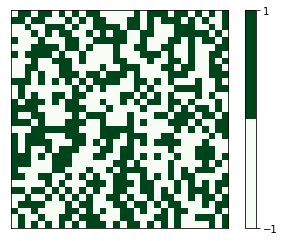

In [92]:
from PIL import Image
from matplotlib import pyplot as plt
new = pertu[0].cpu().numpy()
new =np.transpose(new,[1,2,0])
print(new[:,:,2]*100000)
plt.xticks([])
plt.yticks([])
cmap = plt.get_cmap("Greens",2)
plt.imshow(np.sign(new[:,:,0]),cmap=cmap)
plt.colorbar(ticks=[-1,1])

In [78]:
np.sign(new[:,:,0])

array([[-1.,  1.,  1., ..., -1.,  1.,  1.],
       [-1.,  1.,  1., ..., -1.,  1., -1.],
       [-1., -1., -1., ...,  1., -1., -1.],
       ...,
       [ 1.,  1., -1., ..., -1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1.,  1.,  1.],
       [-1., -1.,  1., ..., -1., -1., -1.]], dtype=float32)

In [21]:
pertu[0][0]

tensor([[-1.3323e-03,  5.7966e-04,  2.1867e-03,  ..., -2.9129e-04,
          4.2409e-04,  3.8189e-04],
        [-9.7728e-04,  1.2236e-03,  6.8736e-04,  ..., -2.8238e-04,
          3.0750e-04, -1.9521e-04],
        [-7.2837e-05, -1.8694e-03, -2.4877e-03,  ...,  1.5491e-04,
         -1.6083e-03, -7.2140e-04],
        ...,
        [ 4.2818e-04,  9.4286e-04, -1.6293e-03,  ..., -9.8526e-05,
          4.7684e-07,  8.9332e-05],
        [ 3.5696e-04, -1.5343e-03,  1.4623e-03,  ...,  5.7370e-04,
          1.6719e-05,  1.2817e-04],
        [-4.1151e-04, -6.9505e-04,  4.9202e-04,  ..., -8.4750e-06,
         -2.1458e-05, -1.2755e-04]], device='cuda:0')

In [34]:
adv_CW= torch.load("advCifarData-0.3-L2-CW.pkl")

In [36]:
adv_CW.shape

torch.Size([82, 3, 32, 32])

array([[[0.5779042 , 0.58188975, 0.605803  , ..., 0.49420774,
         0.45036674, 0.41051126],
        [0.55399096, 0.5500054 , 0.58188975, ..., 0.49022222,
         0.44638118, 0.42246792],
        [0.5500054 , 0.5500054 , 0.5779042 , ..., 0.50217885,
         0.46630892, 0.42645344],
        ...,
        [0.21920507, 0.11558086, 0.07173984, ..., 0.09963867,
         0.        , 0.10760976],
        [0.19130622, 0.14347966, 0.08768203, ..., 0.05181211,
         0.06376874, 0.02789883],
        [0.16340739, 0.1713785 , 0.12753747, ..., 0.04384102,
         0.08369648, 0.03188437]],

       [[0.4030604 , 0.39901477, 0.4192429 , ..., 0.3342847 ,
         0.31810215, 0.2938284 ],
        [0.4030604 , 0.3949691 , 0.41115162, ..., 0.3342847 ,
         0.31810215, 0.3059653 ],
        [0.3949691 , 0.3909235 , 0.39901477, ..., 0.34642157,
         0.3342847 , 0.3100109 ],
        ...,
        [0.45160797, 0.35451284, 0.3059653 , ..., 0.34237596,
         0.20887019, 0.2938284 ],
        [0.4

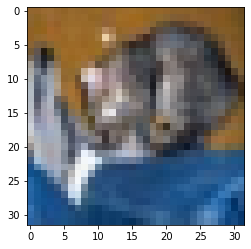

In [208]:
im = images[0].cpu()
show(im)

array([[[0.4386755 , 0.50605035, 0.46983054, ..., 0.7186191 ,
         0.37106797, 0.4673666 ],
        [0.42326224, 0.4342678 , 0.38337395, ..., 0.17982589,
         0.34792072, 0.5142908 ],
        [0.45151532, 0.43659484, 0.4740466 , ..., 0.7933994 ,
         0.31743643, 0.46862596],
        ...,
        [0.4551291 , 0.41671914, 0.4715279 , ..., 0.49120513,
         0.45063925, 0.44384292],
        [0.4718359 , 0.4697484 , 0.4188169 , ..., 0.45429066,
         0.42811823, 0.44531184],
        [0.43729982, 0.47628465, 0.42983273, ..., 0.45484677,
         0.4462076 , 0.44435793]],

       [[0.44728556, 0.5152216 , 0.45360965, ..., 0.71228135,
         0.36514086, 0.49043173],
        [0.43649903, 0.45063925, 0.4108057 , ..., 0.06983875,
         0.34073424, 0.62730306],
        [0.47614095, 0.5036275 , 0.5266515 , ..., 0.76406497,
         0.35146603, 0.41325596],
        ...,
        [0.44406876, 0.38535878, 0.49817944, ..., 0.47553864,
         0.44586197, 0.44943467],
        [0.4

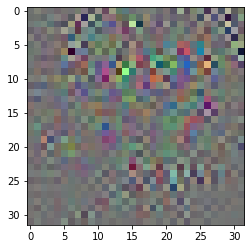

In [209]:
im = pertu[0].cpu()
show(im)

In [261]:

img_adv1 = copy.deepcopy(advs_[0])

In [211]:
def get_single_mask(num):
    x_b = np.zeros((32,32))

    for i in range(num):
        x_axis = np.random.randint(1, 31)
        y_axis = np.random.randint(1, 31)
        case_radom = np.random.randint(1, 5)
        
        if (case_radom == 1) :
            x_b[x_axis][y_axis] = 1
        
        elif (case_radom == 2) :
            x_b[x_axis][y_axis+1] = 1
        
        elif (case_radom == 3) :
            x_b[x_axis+1][y_axis] = 1
        
        elif (case_radom == 4) :
            x_b[x_axis+1][y_axis+1] = 1
    
#     x_b_msk = np.img_as_ubyte(x_b)
    return x_b

In [212]:
try_times = 11
def get_masks(num):

    mask = np.expand_dims(get_single_mask(num), axis = 0)
    for k in range(try_times-1):
        mask2 = np.expand_dims(get_single_mask(num), axis = 0)
        mask = np.concatenate((mask, mask2))
    
    # print(mask.shape) ->  (11, 224, 224)
    return mask

In [272]:
# mask = get_masks(300)
dst_adv.shape

(32, 32, 3)

In [230]:
src = img_adv1.cpu().detach().numpy()

In [231]:
src = np.transpose(src,[2,1,0])

In [276]:
classes[pred[0]]

'cat'

In [144]:
rgb_img = cv2.cvtColor(np.expand_dims(mask[5],axis=2), cv2.COLOR_BGR2RGB)

error: OpenCV(4.5.2) /tmp/pip-req-build-13uokl4r/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [171]:
new = np.expand_dims(mask[5],axis=2)

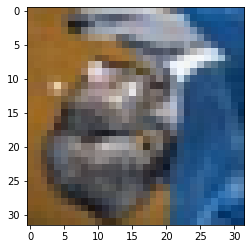

In [237]:
plt.imshow(src,cmap='Greys_r')

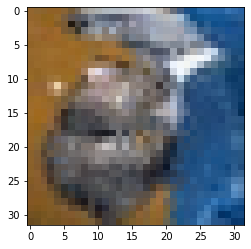

In [245]:
plt.imshow(dst_adv,cmap='Greys_r')

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [ 39,  29,  22],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [248,   1,   3],
       [  0,   0,   0],
       [242, 243, 242],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0]], dtype=uint8)

In [252]:
model.features

Sequential(
  (init_block): ConvBlock(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ): ReLU(inplace=True)
  )
  (stage1): Sequential(
    (unit1): ResUnit(
      (body): ResBlock(
        (conv1): ConvBlock(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (conv2): ConvBlock(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (activ): ReLU(inplace=True)
    )
    (unit2): ResUnit(
      (body): ResBlock(
        (conv1): ConvBlock(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), str